<a href="https://colab.research.google.com/github/VSCHY/RiverNetwork/blob/master/Toy_Model_Large_basin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Description of the toy model </h1>
<hr>

<center>

![image](https://drive.google.com/uc?export=view&id=1TAd3t-rDnwhBaIuISNdxclXb4WLElJsz)

<em>Figure 1: Description of the HTUs toy model in series </em>
</center>

River dynamic Parameter : 
*   tcst : time constant of the reservoir
*   topoindex

In this model we consider a basic time unit = 1. Then the subdivision of the time unit are defined by subdt. For exemple, subdt = 2 corresponds to two time step inside the basic unit, i.e. a time step of 0.5.

Time parameters :
*   niter : number of iteration
*   subdt : number of subdivision of 1 time unit

Formula to define the discharge out of i : 

Qi = 1/(tcst*topoindex)*Vi * dt

The outflow discharge is Qout = Qnhtus

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class experiment:
  def __init__(self, D, V= None, Qin = 0):
    """
    D : Initialization of the parameters values from the dictionnary
    V : Array with the initial state of the different reservoir (possible to describe as a list)
    Qin : inflow in the first reservoi
    """
    self.tcst = D["tcst"]
    self.topoindex = D["topoindex"]
    self.nhtus = D["nhtus"]
    # 
    self.subdt =D["subdt"]
    # subdt describe the time step, it is the number of division of the basic time step   
    self.dt = 1/self.subdt
    # 
    self.niter = D["niter"] 
    self.f_cst = 1/(self.tcst * self.topoindex)
    self.init_var()
    if V is not None:
        self.V[:] = V
    self.Qin = Qin

  def init_var(self):
    """
    Initialization of volume and discharge for each reservoir
    """
    self.V = np.zeros((self.nhtus))
    self.Q = np.zeros((self.nhtus))  
  
  def launch(self, volume_hist = False):
     """
     Run the experiment, the output are the mean discharge over each basic unit of time
     and for each iteration
     """
     if volume_hist: hist_V = np.zeros((self.nhtus, self.subdt*self.niter))
     hist_out = np.zeros(self.subdt*self.niter)
     for it in range(self.niter):
        for t in range(self.subdt):
          if volume_hist: hist_V[:, it * self.subdt + t] = self.V[:]
          temp = np.zeros((2,self.V.shape[0]))
          temp[0,:] = self.V*self.f_cst*self.dt; temp[1,:] = self.V
          self.Q = np.min(temp, axis = 0)

          self.V = self.V-self.Q
          hist_out[it * self.subdt + t] = self.Q[-1]
          self.V[1:] += self.Q[:-1]
          self.V[0] += self.Qin

     # Mean de subdt sur les subdt
     hist_out = np.mean(np.reshape(hist_out, (-1,self.subdt)), axis = 1)
     if volume_hist: 
        hist_V = np.mean(np.reshape(hist_V, (self.nhtus,-1,self.subdt)), axis = 2)
        return hist_out, hist_V
     else:
        return hist_out

####

def get_param(tcst = 0.0035, topoindex = 300, nhtus = 1, subdt = 1, niter = 1000):
    """
    Function to define the Dictionnary parameters.
    This is simplified by using default values.
    """
    D = {"tcst": tcst, "topoindex":topoindex, "nhtus" :nhtus, "subdt":subdt,  "niter":niter}
    return D

<h1> Large river example </h1>
<hr>
Let's consider a large river with a regular decomposition in HTUs :
the length of the river is 3000km with a 4 km difference of altitude. 
The topoindex is adjusted to the number of HTUs considered. 

In this first example we consider a subdt = 3, tcst = 0.035 and a number of htus between 2000 and 9000.

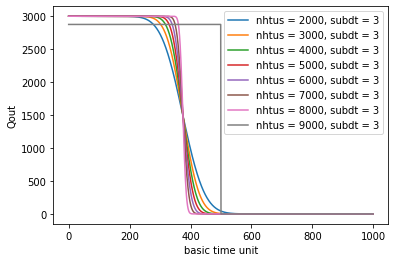

'\n########################\nm = ["o", "s", ".", "s","^", ">"]\n# plt.plot avec les différent dt pour chaque ligne en axe x\n# en y le tau \nfor subdt in D.keys():\n  plt.scatter(np.arange(1000,22000,5000), D[subdt], marker = m[subdt])\n'

In [8]:
# Experiment
"""
We take subdt = 3. The volume are set at equelibrium for a Qin = 1000.
The simulation have Qin = 0 -> let see how the htus will empty
"""

# Qinit = V*1/(self.tcst * self.topoindex)*dt
# 30 000 * self.tcst * self.topoindex / dt  = V 

length = 3000 #(km)
dz = 4 #(km)
t0 = length/1000/np.sqrt((dz/length))
tcst = 0.035
subdt = 3
Lout = []; Lname = []
for nhtus in np.arange(2000,10000,1000):
      topoindex = length/nhtus/np.sqrt((dz/length))
      V0 =  3000 * tcst * topoindex * subdt
      exp0 = experiment(get_param(subdt = subdt,  topoindex = topoindex, tcst = tcst, nhtus = nhtus, niter = 4000), [V0]*nhtus)
      Lout.append(exp0.launch()); Lname.append("nhtus = {0}, subdt = {1}".format(nhtus, subdt))

for i in range(len(Lout)):
    plt.plot(Lout[i][2500:3500], label = Lname[i])
plt.ylabel("Qout")
plt.xlabel("basic time unit")
plt.legend()
plt.show()
"""
D = {}
for subdt in [3,5,10,15,20]: 
  Lout = []; Lname = []
  for nhtus in np.arange(1000,22000,5000):
      topoindex = length/nhtus/np.sqrt((dz/length))
      exp0 = experiment(get_param(subdt = subdt,  topoindex = topoindex, nhtus = nhtus, niter = 10000), [90000*topoindex/t0]*nhtus)
      Lout.append(exp0.launch()); Lname.append("nhtus = {0}, subdt = {1}".format(nhtus, subdt))

  for i in range(len(Lout)):
    plt.plot(Lout[i][:], label = Lname[i])
  plt.ylabel("Qout")
  plt.xlabel("basic time unit")
  plt.legend()
  plt.show()

  D[subdt] = [np.argmin(np.abs(Lout[i][:]-5000)) for i in range(len(Lout))]
"""
# Voir quand c'est égal à 5000



"""
########################
m = ["o", "s", ".", "s","^", ">"]
# plt.plot avec les différent dt pour chaque ligne en axe x
# en y le tau 
for subdt in D.keys():
  plt.scatter(np.arange(1000,22000,5000), D[subdt], marker = m[subdt])
"""

<h2> Conclusion </h2>
The simulations have a different behaviour, the higher the number of HTUs the later the reaction to Qin = 0 in the beginning of the river.
At some point the evolution of Qout is too strong, such as with nhtus = 9000.

In reality, the river may face many variations, and the system will "absorb" these variations.

We may observe 2 indexes : the time to reach 66% of the initial Qin and the time to reach 33%.

<h2> Second part </h2>

Start running
subdt: 3
subdt: 5


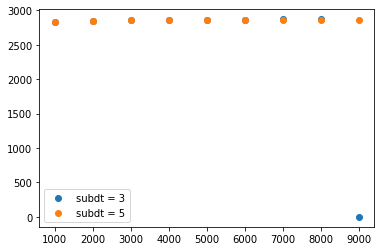

In [17]:
# Experiment
"""
FIRST TRY with subdt = 3 and subdt = 5
"""

# Qinit = V*1/(self.tcst * self.topoindex)*dt
# 30 000 * self.tcst * self.topoindex / dt  = V 
def get_config(length = 3000, dz = 4, tcst = 0.035, subdt = 3):
  config = {"length" : length, "dz" : dz, "tcst" : tcst, "subdt" : subdt}
  return config

def make_experiment(config, Lnhtus):
  Lout = []
  for nhtus in Lnhtus:
      topoindex = length/nhtus/np.sqrt((dz/length))
      # Qinit = V*1/(self.tcst * self.topoindex)*dt
      Qinit = 3000 
      V0 =  Qinit * tcst * topoindex * subdt 
      exp0 = experiment(get_param(subdt = subdt,  topoindex = topoindex, tcst = tcst, nhtus = nhtus, niter = 4000), [V0]*nhtus)
      Lout.append(exp0.launch()); Lname.append("nhtus = {0}, subdt = {1}".format(nhtus, subdt))
  return Lout

D1 = {}
D2 = {}
Lnhtus = np.arange(1000,10000,1000)
print("Start running")
for subdt in [3,5]: 
  print("subdt: {0}".format(subdt))
  config = get_config(subdt = subdt)
  Lout = make_experiment(config, Lnhtus)
  D1[subdt] = [np.argmin(np.abs(Lout[i][:]-2000)) for i in range(len(Lout))]
  D2[subdt] = [np.argmin(np.abs(Lout[i][:]-1000)) for i in range(len(Lout))]
  #

for subdt in [3, 5]:
  plt.scatter(Lnhtus, D1[subdt], label = "subdt = {0}".format(subdt))
plt.legend()
plt.show()

Both simulations are really close one to another except for subdt = 3 and nhtus = 9000. This example was unstable with an abrubt change and thus = 0.
This unstability is resolved at subdt = 5. 

For the following experiences we may limit nhtus to 8000.

**NOTATION**

*   T1 : Time at Q = 2/3 Qin(t=0)
*   T2 : Time at Q = 1/3 Qin(t=0)



Start running
subdt: 3
subdt: 5
subdt: 7
subdt: 9
subdt: 10
subdt: 12


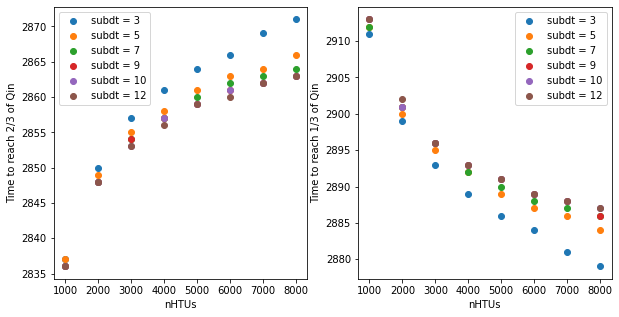

In [19]:
# Experiment
"""
FIRST TRY with subdt = 3 and subdt = 5
"""

# Qinit = V*1/(self.tcst * self.topoindex)*dt
# 30 000 * self.tcst * self.topoindex / dt  = V 
def get_config(length = 3000, dz = 4, tcst = 0.035, subdt = 3):
  config = {"length" : length, "dz" : dz, "tcst" : tcst, "subdt" : subdt}
  return config

def make_experiment(config, Lnhtus):
  Lout = []
  for nhtus in Lnhtus:
      topoindex = length/nhtus/np.sqrt((dz/length))
      # Qinit = V*1/(self.tcst * self.topoindex)*dt
      Qinit = 3000 
      V0 =  Qinit * tcst * topoindex * subdt 
      exp0 = experiment(get_param(subdt = subdt,  topoindex = topoindex, tcst = tcst, nhtus = nhtus, niter = 4000), [V0]*nhtus)
      Lout.append(exp0.launch()); Lname.append("nhtus = {0}, subdt = {1}".format(nhtus, subdt))
  return Lout

D1 = {}
D2 = {}
# Here we limit to 9000
Lnhtus = np.arange(1000,9000,1000)
Lsubdt = [3,5, 7, 9, 10, 12]
print("Start running")
for subdt in Lsubdt: 
  print("subdt: {0}".format(subdt))
  config = get_config(subdt = subdt)
  Lout = make_experiment(config, Lnhtus)
  D1[subdt] = [np.argmin(np.abs(Lout[i][:]-2000)) for i in range(len(Lout))]
  D2[subdt] = [np.argmin(np.abs(Lout[i][:]-1000)) for i in range(len(Lout))]
  #
fig = plt.figure(figsize = (10, 5))
#
fig.add_subplot(121)
for subdt in Lsubdt:
  plt.scatter(Lnhtus, D1[subdt], label = "subdt = {0}".format(subdt))
plt.legend()
plt.xlabel("nHTUs")
plt.ylabel("Time to reach 2/3 of Qin")
plt.title("T1")
#
fig.add_subplot(122)
for subdt in Lsubdt:
  plt.scatter(Lnhtus, D2[subdt], label = "subdt = {0}".format(subdt))
plt.xlabel("nHTUs")
plt.ylabel("Time to reach 1/3 of Qin")
plt.title("T2")
plt.legend()
plt.show()

<h2> Conclusion </h2>

**Impact of nhtus**

*   The higher nhtus, the higher T1
*   The higher nhtus, the lower T2

Lower nhtus "smooth" the discharge.

**Impact of subdt**

*REMINDER : A higher subdt means a shorter timestep.*

The différence between the subdt is higher as the subdt raise. 
The higher subdt (the shorter the timestep), the lower T1 and the higher T2.
Raising the time step "smooth" the discharge.


<h1> Additional </h1>
We may consider that in a real system we have many different interactions and variations. Thus the predominent effect in a large basin may be the "T1" effect. Thus, high number of HTUs lower the sensibility of the river networks to discharge change. At a certain point it may become critical and then we may have a almost constant discharge.

The same may happen with too low subdt.

Of course this issue will depend on the choosen time constant and the topography of the catchment (here represented as length and dz). 